In [10]:
!pip install noisereduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio
import noisereduce as nr 

import librosa
import librosa.display
import scipy
import IPython.display as ipd
from scipy.io.wavfile import read,write
from IPython.display import Audio
from scipy.fftpack import fft
import scipy.fftpack as fft
from scipy import signal
import sys, os, wave
from scipy.io import wavfile
from scipy.signal import get_window

ModuleNotFoundError: No module named 'noisereduce'

# Loading the data

In [11]:
data,Fs=librosa.load('PinkPanther30.wav', sr=None) #Fs is the sampling frequency of the song
plt.plot(data)
Audio(data,rate=Fs)
chunks=np.array_split(data,2)
len(chunks[0])

/Users/adityajolly/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'PinkPanther30.wav'

# Noise reduction

In [30]:
reduced_noise = nr.reduce_noise(y=chunks[0], sr=Fs)
reduced_noise.shape

(330750,)

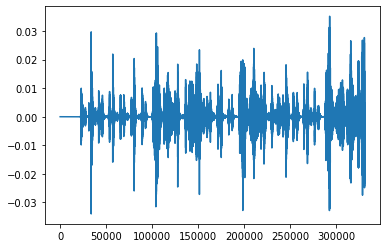

In [31]:
plt.plot(reduced_noise)

# Zero Crossing Rate

In [32]:
def zero_crossing_rate(chunk):
    zero_crossing_rate=librosa.feature.zero_crossing_rate(chunk,frame_length=2048, hop_length=512, center=False)
    return zero_crossing_rate

In [33]:
zero_crossing_rate(reduced_noise).shape

(1, 642)

# Spectral Centroid

In [34]:
def spectral_centroid(chunk):
    centroid=librosa.feature.spectral_centroid(chunk, sr=22050, S=None, n_fft=2048, hop_length=512, freq=None, win_length=None, window='hann', center=True, pad_mode='reflect')
    return centroid

In [35]:
spectral_centroid(reduced_noise).shape

(1, 646)

# Pitch detection

In [36]:
def normal_distribution(w):
    width = w+1
    weights = np.exp(-np.square([2*x/width for x in range(width)]))
    weights = np.pad(weights, (width-1,0), 'reflect')
    weights = weights/np.sum(weights)
    return weights
def detect_pitch(int_data):
    all_pitches=[]
    if 'avg' not in detect_pitch.__dict__:
        detect_pitch.avg = 0
    WIND = 10
    CYCLE = 400
    RATE=Fs
    weights = normal_distribution(WIND)
    windowed_data = np.pad(int_data, WIND, 'reflect')
    smooth_data = np.convolve(int_data, weights, mode='valid')
    smooth_pitches = [0]+[np.mean(smooth_data[:-delay] - smooth_data[delay:]) for delay in range(1,CYCLE)]

    dips = [x for x in range(WIND, CYCLE-WIND) if smooth_pitches[x] == np.min(smooth_pitches[x-WIND:x+WIND])]
    if len(dips) > 1:
        av_dip = np.mean(np.ediff1d(dips))
        cheq_freq = RATE / av_dip
        detect_pitch.avg = detect_pitch.avg*0.5 + cheq_freq*0.5
        all_pitches.append(int(detect_pitch.avg))
        print('\r'+str(int(detect_pitch.avg))+' Hz        ', end='')
    return int(detect_pitch.avg)

In [37]:
detect_pitch(reduced_noise)

157 Hz        

157

# MFCC Calculation

In [38]:
def mel_frequency(data):
    FFT_size=2048
    hop_size=15# hop_size in ms  
    data = np.pad(data, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(Fs * hop_size / 1000).astype(int)
    frame_num = int((len(data) - FFT_size) / frame_len) + 1
    framed_data = np.zeros((frame_num,FFT_size))

    for n in range(frame_num):
        framed_data[n] = data[n*frame_len:n*frame_len+FFT_size]

    #taking a hanning window and multiplying it to the framed data
    FFT_size=2048
    hanning_window = get_window("hann", FFT_size, fftbins=True)
    windowed_data = framed_data * hanning_window
    ind = 69
    fft_data = np.empty((int(1 + FFT_size // 2), windowed_data.shape[0]), dtype=np.complex64, order='F')

    for n in range(fft_data.shape[1]):
        fft_data[:, n] = fft.fft((windowed_data[n,:]).T, axis=0)[:fft_data.shape[0]]

    fft_data = np.transpose(fft_data)
    data_power=np.square(np.abs(fft_data))
    #get the filter bank splitting points
    freq_min = 0
    freq_max = Fs / 2
    mel_filter_num = 10

    freq_min_mel = 2595.0 * np.log10(1.0 + freq_min / 700.0)
    freq_max_mel = 2595.0 * np.log10(1.0 + freq_max / 700.0)

    mel_freq = np.linspace(freq_min_mel, freq_max_mel, num=mel_filter_num+2)
    freq_set = 700.0 * (10.0**(mel_freq / 2595.0) - 1.0)

    filter_points=np.floor((FFT_size + 1) / Fs * freq_set).astype(int)
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    # taken from the librosa library
    enorm = 2.0 / (mel_freq[2:mel_filter_num+2] - mel_freq[:mel_filter_num])
    filters *= enorm[:, np.newaxis]
    audio_filtered = np.dot(filters, np.transpose(data_power))
    audio_log = 10.0 * np.log10(audio_filtered)
    dct_filter_num = 40
    basis = np.empty((dct_filter_num,mel_filter_num))
    basis[0, :] = 1.0 / np.sqrt(mel_filter_num)

    samples = np.arange(1, 2 * mel_filter_num, 2) * np.pi / (2.0 * mel_filter_num)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / mel_filter_num)

    cepstral_coefficents = np.dot(basis, audio_log)
    cepstral_coefficents.shape
    return cepstral_coefficents
    

In [39]:
mel_frequency(chunks[0]).shape

/var/folders/c2/tk0nr7k97gs06t559smt6r000000gn/T/ipykernel_48487/3488516083.py:45: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


(40, 1000)

In [2]:
def final_Features():
    #Loading the song
    data,Fs=librosa.load('.wav', sr=None) #Fs is the sampling frequency of the song
    Audio(data,rate=Fs)
    #noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=Fs)
    #zero_crossing_rate
    zc=zero_crossing_rate(reduced_noise)
    #spectral centroid
    sc=spectral_centroid(reduced_noise)
    #detecting pitch
    pitch=detect_pitch(reduced_noise)
    #mfcc
    mfcc=mel_frequency(reduced_noise)
    return(zip(zc,sc,pitch,mfcc))
    
    
    

In [6]:
x=final_Features()

/Users/adityajolly/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'PinkPanther30.wav'